# Chest diseases classification

## Librairies and data

In [37]:
! pip freeze > requirements/requirements.txt
# ! pip install requirements/requirements.txt

In [6]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import gc
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import time
import seaborn as sns
import torchmetrics
from torchsummary import summary


In [7]:
# od.download("https://www.kaggle.com/datasets/nih-chest-xrays/data")

In [8]:
data_path = "data"

## Data preparation

In [9]:
df = pd.read_csv("data/Data_Entry_2017.csv")
df = df.drop(df[df["Finding Labels"]=="No Finding"].index)

In [10]:
df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143000,0.143000
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143000,0.143000
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168000,0.168000
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143000,0.143000
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168000,0.168000
...,...,...,...,...,...,...,...,...,...,...,...
112097,00030786_007.png,Consolidation|Pleural_Thickening,7,30786,61,F,AP,3056,2544,0.139000,0.139000
112100,00030789_000.png,Infiltration,0,30789,52,F,PA,2021,2021,0.194311,0.194311
112106,00030793_000.png,Mass|Nodule,0,30793,58,F,PA,2021,2021,0.194311,0.194311
112108,00030795_000.png,Pleural_Thickening,0,30795,53,F,PA,2021,2021,0.194311,0.194311


In [11]:
def disp_nan(df): 
    nb_nan = pd.DataFrame([df[c].isnull().value_counts() for c in df.columns], index = df.columns)
    nb_nan.rename(columns={"False" : "Not NaN", "True" : "NaN"})
    return nb_nan

disp_nan(df)

,False
Image Index,51759
Finding Labels,51759
Follow-up #,51759
Patient ID,51759
Patient Age,51759
Patient Gender,51759
View Position,51759
OriginalImage[Width,51759
Height],51759
OriginalImagePixelSpacing[x,51759


In [12]:
df = df.dropna()

In [13]:
df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143000,0.143000
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143000,0.143000
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168000,0.168000
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143000,0.143000
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168000,0.168000
...,...,...,...,...,...,...,...,...,...,...,...
112097,00030786_007.png,Consolidation|Pleural_Thickening,7,30786,61,F,AP,3056,2544,0.139000,0.139000
112100,00030789_000.png,Infiltration,0,30789,52,F,PA,2021,2021,0.194311,0.194311
112106,00030793_000.png,Mass|Nodule,0,30793,58,F,PA,2021,2021,0.194311,0.194311
112108,00030795_000.png,Pleural_Thickening,0,30795,53,F,PA,2021,2021,0.194311,0.194311


In [14]:
# display all chest diseases
# print(df['Finding Labels'].value_counts())

labels = np.unique(df["Finding Labels"])
all_labels = []
for x in labels : 
    all_labels += x.split('|')
labels = np.unique(all_labels)
s = ''
for i,l in enumerate(labels) : 
    s+=f'\n {i} - '+l
print(f"{len(labels)} unique chest diseases : "+s)



14 unique chest diseases : 
Atelectasis
Cardiomegaly
Consolidation
Edema
Effusion
Emphysema
Fibrosis
Hernia
Infiltration
Mass
Nodule
Pleural_Thickening
Pneumonia
Pneumothorax
['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'Nodule'
 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


In [15]:
df_finding_labels = df["Finding Labels"].str.get_dummies('|')
df = pd.concat([df,df_finding_labels], axis = 1)
df = df.drop('Finding Labels', axis = 1)

In [17]:
# converting all categorical columns
cat_cols = df.select_dtypes(include='object').columns
cat_cols = cat_cols.drop('Image Index')

enc = OneHotEncoder()
new_cols = enc.fit_transform(df[cat_cols]).toarray()
names = enc.get_feature_names_out()
new_cols = pd.DataFrame(new_cols, columns=names, index = df.index)

df = pd.concat([df,new_cols], axis = 1)

df = df.drop(cat_cols, axis = 1)

df

,Image Index,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Atelectasis,Cardiomegaly,...,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Patient Gender_F,Patient Gender_M,View Position_AP,View Position_PA
0,00000001_000.png,0,1,58,2682,2749,0.143000,0.143000,0,1,...,0,0,0,0,0,0,0.0,1.0,0.0,1.0
1,00000001_001.png,1,1,58,2894,2729,0.143000,0.143000,0,1,...,0,0,0,0,0,0,0.0,1.0,0.0,1.0
2,00000001_002.png,2,1,58,2500,2048,0.168000,0.168000,0,1,...,0,0,0,0,0,0,0.0,1.0,0.0,1.0
4,00000003_000.png,0,3,81,2582,2991,0.143000,0.143000,0,0,...,0,0,0,0,0,0,1.0,0.0,0.0,1.0
5,00000003_001.png,1,3,74,2500,2048,0.168000,0.168000,0,0,...,0,0,0,0,0,0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112097,00030786_007.png,7,30786,61,3056,2544,0.139000,0.139000,0,0,...,0,0,0,1,0,0,1.0,0.0,1.0,0.0
112100,00030789_000.png,0,30789,52,2021,2021,0.194311,0.194311,0,0,...,1,0,0,0,0,0,1.0,0.0,0.0,1.0
112106,00030793_000.png,0,30793,58,2021,2021,0.194311,0.194311,0,0,...,0,1,1,0,0,0,1.0,0.0,0.0,1.0
112108,00030795_000.png,0,30795,53,2021,2021,0.194311,0.194311,0,0,...,0,0,0,1,0,0,1.0,0.0,0.0,1.0


In [ ]:
# # display 9 random images
# random_index = np.random.choice(range(N),9)
# plt.figure(figsize = (100,100))
# for i in range(9):
#     index = random_index[i]
#     plt.subplot(3, 3, i + 1)
#     img = plt.imread(images_names[index])
#     plt.imshow(img, cmap='gray')
#     title = np.array(df_finding_labels)[index]+"\n"+np.array(df["Image Index"])[index]
#     plt.title(title, fontsize = 100)
#     plt.axis('off')


## Data exploration


In [ ]:
# df_for_analysis = df.copy()
# df_for_analysis = df_for_analysis.drop(['Image Index', 'Patient ID'], axis = 1)
# sns.heatmap(df_for_analysis.corr())
# plt.title('correlation between the different cases')

Text(0.5, 1.0, 'repartition of the different cases')

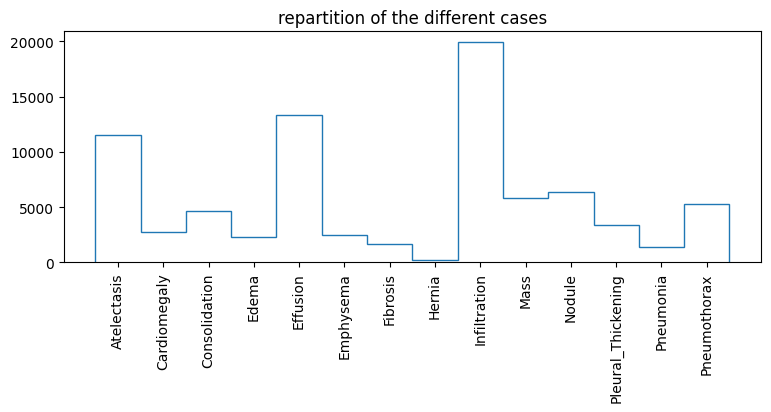

In [18]:
# repartition of the different cases 
histo = [df_finding_labels[c].sum() for c in df_finding_labels.columns]
plt.figure(figsize = (9, 3))
plt.stairs(histo)
plt.xticks(np.arange(0.5,14.5), df_finding_labels.columns, rotation = 90)
plt.title('repartition of the different cases')

Text(0.5, 1.0, 'correlation between the different cases')

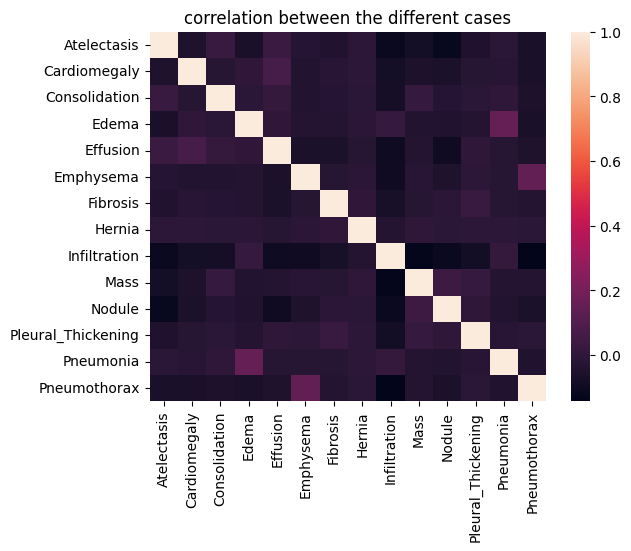

In [19]:
# correlation between the different cases
sns.heatmap(df_finding_labels.corr())
plt.title('correlation between the different cases')

We observe that some diseases are present together such as Pneumothorax and Emphysema or Penumonia and Edema. They can be co-morbidities or the NLP extraction might have extracted both names if doctors suggested both diseases for the patient. After some research on internet, emphysema can make patients more susceptible to pneumothorax, as well as edema for pneumonia.

## Build model 

In [20]:
# get images
import glob
images_names = np.array(glob.glob('data/images_*/images/*.png'))[df.index]
N = len(images_names)
print("The dataset contains {} images.".format(N))



The dataset contains 51759 images


In [21]:
images_names_train, images_names_test, labels_train, labels_test = train_test_split(images_names, df_finding_labels , test_size = 0.05)

In [22]:
import cv2 as cv
import torch
from torch import nn

The three channels are the same, we can just keep one.

In [23]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [24]:
# training parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 128
N_EPOCHS = 2

IMG_SIZE = 1024 // 8
N_CLASSES = 14

In [25]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, N_CLASSES)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * (IMG_SIZE // 8) * (IMG_SIZE // 8))
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x





In [36]:
model = CNN().to(device)
summary(model, (1, IMG_SIZE, IMG_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             320
         MaxPool2d-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          18,496
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
         MaxPool2d-6          [-1, 128, 16, 16]               0
            Linear-7                  [-1, 256]       8,388,864
           Dropout-8                  [-1, 256]               0
            Linear-9                   [-1, 14]           3,598
Total params: 8,485,134
Trainable params: 8,485,134
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 8.75
Params size (MB): 32.37
Estimated Total Size (MB): 41.18
-------------------------------------

In [27]:
import torch.optim as optim
torch.manual_seed(RANDOM_SEED)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
accuracy = torchmetrics.Accuracy(task="multilabel", num_labels=N_CLASSES)


In [28]:
trainloader = torch.utils.data.DataLoader(list(zip(images_names_train, labels_train.to_numpy())) , batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
                                          
testloader = torch.utils.data.DataLoader(list(zip(images_names_test, labels_test.to_numpy())) , batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)                                          

In [29]:
print(len(trainloader))
print(len(testloader))


385
21


In [30]:
import gc

In [31]:
from tqdm import tqdm


In [32]:
def train(model, trainloader, testloader) : 

    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []
    
    for epoch in range(N_EPOCHS):  # loop over the dataset multiple times


        running_loss = 0.0
        running_accuracy = 0.0

        with tqdm(trainloader, unit='batch', total = len(trainloader)) as tepoch :
            for X_batch, y_batch in tepoch:
                tepoch.set_description(f"Epoch {epoch+1}")

                # get inputs and labels
                labels = y_batch.to(device).float()
                inputs = []
                for x in X_batch : 
                    inputs.append(cv.resize(cv.imread(x)[:,:,0], (IMG_SIZE, IMG_SIZE)))
                inputs = np.array(inputs)
                inputs = torch.Tensor(inputs).to(device).reshape((len(inputs), 1, IMG_SIZE,IMG_SIZE))

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # get statistics
                l = loss.item() / len(labels) 
                running_loss += l
                acc = accuracy(outputs, labels).item()
                running_accuracy += acc
                tepoch.set_postfix(loss = l, accuracy = acc)
                time.sleep(1.0)

                # optimize memory
                del inputs
                del labels
                del outputs
                gc.collect()

        # saving model
        path = f"saved_models/model_{epoch+1}epochs.pkl"
        torch.save(model.state_dict(), path)
            
        # saving training loss and test loss 
        train_loss.append(running_loss)
        train_accuracy.append(running_accuracy)
        test_results = test(model, criterion, testloader)
        test_loss.append(test_results['loss'])
        test_accuracy.append(test_results['accuracy'])
            
    print('Finished Training')


    return {'model' : model, 'training loss' : train_loss, 'training accuracy' : train_accuracy, 'test loss' : test_loss, 'test accuracy' : test_accuracy}

In [33]:
def test(model, criterion, testloader) : 

    running_loss = 0.0
    running_accuracy = 0.0
    
    with tqdm(testloader, unit='batch', total = len(testloader)) as tepoch :
        for X_batch, y_batch in tepoch:
            tepoch.set_description(f"Testing")
            # get inputs and labels
            labels = y_batch.to(device).float()
            inputs = []
            for x in X_batch : 
                inputs.append(cv.resize(cv.imread(x)[:,:,0], (IMG_SIZE, IMG_SIZE)))
            inputs = np.array(inputs)
            inputs = torch.Tensor(inputs).to(device).reshape((len(inputs), 1, IMG_SIZE,IMG_SIZE))
        
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            l = loss.item() / len(labels)
            running_loss += l
            acc = accuracy(outputs, labels).item()
            running_accuracy += acc
    
            # tepoch.update(BATCH_SIZE)

    tepoch.set_postfix(loss = running_loss, accuracy = running_accuracy)
    # tepoch.close()

    return {'loss' : running_loss, 'accuracy' : running_accuracy }

In [34]:
results = train(model, trainloader, testloader)
train_loss = results['training loss'] 
train_accuracy = results['training accuracy']
test_loss = results['test loss']
test_accuracy = results['test accuracy']

Testing: 100%|██████████| 21/21 [00:53<00:00,  2.56s/batch]

Finished Training


In [38]:
def plot_stats(train_loss, train_accuracy, test_loss, test_accuracy):
    f, (ax1, ax2) = plt.subplots(1, 2)
    epochs = np.arange(1,len(train_loss)+1)
    print(epochs)
    # plt.plot()

    ax1.plot(epochs, train_loss, label = 'training loss') 
    ax1.plot(epochs, test_loss, label = 'test loss')
    # ax1.xlabel('Number of epochs')
    # ax1.title('Loss')

    ax2.plot(epochs, train_accuracy, label = 'training accuracy') 
    ax2.plot(epochs, test_accuracy, label = 'test accuracy')
    # ax2.xlabel('Number of epochs')
    # ax2.title('Accuracy')

    plt.title('Loss and accuracy evolution along epochs')

    plt.show()

[1]


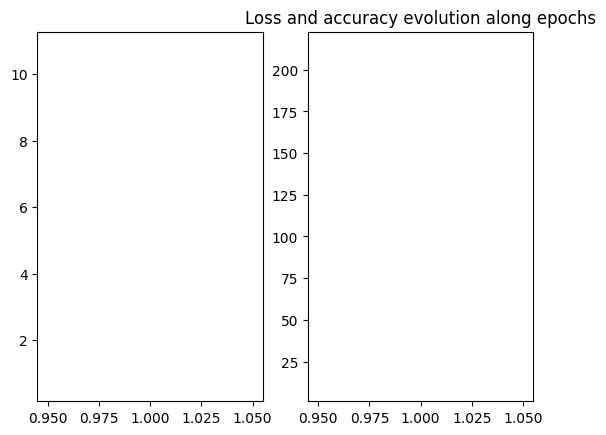

In [39]:
plot_stats(train_loss, train_accuracy, test_loss, test_accuracy)

In [41]:
train_loss

[10.770333662629128]

In [ ]:
path = "saved_models/model.pkl"
torch.save(model.state_dict(), path)

In [ ]:
model = CNN().to(device)
model.load_state_dict(torch.load(path))

In [ ]:
dict = {'loss' : 0, 'accuracy' : 1}
dict['loss']